In [1]:
from autoencoder_trainer import *

In [2]:
training_dir = "/Users/afq/Google Drive/networks/"
data_dir = "/Users/afq/Dropbox/ML/primaryautoencoder/data_files/"
n_epoch = 25000
dataset = tf.data.experimental.make_csv_dataset(
    data_dir+'water_lg_sharded/*.csv',
    5000,
    select_columns=['T',' p',' rho',' h'],
    column_defaults=[tf.float64,tf.float64,tf.float64,tf.float64]
)
# hyper = {'type':'Poly','args':[1,7]}
hyper = {'type':'Classifying','args':[1,3, 6,12,'sigmoid']}
name = "water_lg"
outerdim,innerdim=4,2

In [3]:
data_all = np.load(data_dir+"water_lg_scaled_train.npy")

In [4]:
dataset_all = tf.data.Dataset.from_tensors(data_all)

In [5]:
dataset_all_from_shards = tf.data.experimental.make_csv_dataset(
    data_dir+'water_lg_sharded/*.csv',
    10000,
    select_columns=['T',' p',' rho',' h'],
    column_defaults=[tf.float64,tf.float64,tf.float64,tf.float64]
)

In [6]:
autoclass = autoencoder_factory[hyper['type']]
def sanitize(x):
    return str(x).replace(' ','').replace('[','(').replace(']',')')
hyperpath = hyper['type']+'_'+','.join(map(sanitize,hyper['args']))
training_dir = training_dir+"/training_"+name+"/"+hyperpath

In [7]:
stream = atu.make_datastream(dataset,batch_size=0,buffer_size=1000)
stream = tf.transpose(stream)
global_step = tf.train.get_or_create_global_step()
onum = tf.Variable(0,name="csv_output_num")
stream_all = dataset_all.repeat().make_one_shot_iterator().get_next()
ae = autoclass(outerdim, innerdim, stream, *hyper['args'], data_all=stream_all)
init = tf.global_variables_initializer()

In [8]:
# alpha = tf.Variable(0.1,dtype=tf.float64)
newt_select = atu.NewtonsMethod(ae.goal_all, [ae.vars['dec_W_select']],alpha=0.05)
#newt_bound = atu.NewtonsMethod(ae.goal_all, [ae.vars['dec_W_bound'],ae.vars['dec_b_bound']])

[(0, 72)]
(72, 1)


In [9]:
session = tf.train.MonitoredTrainingSession(
            checkpoint_dir=training_dir)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /Users/afq/Google Drive/networks//training_water_lg/Classifying_1,3,6,12,sigmoid/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15000 into /Users/afq/Google Drive/networks//training_water_lg/Classifying_1,3,6,12,sigmoid/model.ckpt.


In [11]:
prev_val = session.run(ae.vars["dec_W_curve"])
prev_val

array([[[-4.49193500e-01, -9.42413776e-01,  4.64288804e-01,
         -4.32534551e-01],
        [-8.03622040e-01, -5.88860994e-01,  1.50214430e-01,
         -2.85146631e-01],
        [-3.77054259e-01, -6.80454366e-01,  4.01666019e-01,
         -4.44500725e-01],
        [-1.77069205e-01, -9.15899592e-01,  5.97771866e-01,
         -1.96464619e-01],
        [-2.59115496e-01, -7.65210252e-01,  3.39360361e-01,
         -2.30820910e-01],
        [ 8.07865700e-03, -1.26170211e+00,  9.06941086e-01,
         -6.46782512e-01]],

       [[ 1.57094325e-01, -2.06928024e-01, -6.33083597e-01,
          5.28151826e-01],
        [ 2.32822504e-01, -8.83541042e-01, -5.40053062e-01,
          4.47388196e-01],
        [ 2.07027949e-01, -3.95492107e-01, -3.63375074e-01,
          3.78809540e-01],
        [ 8.18963559e-02, -3.87523553e-01, -6.23557064e-01,
          5.57118993e-01],
        [ 2.04845573e-01, -5.41850342e-01, -3.97508187e-01,
          3.93648243e-01],
        [-8.30213265e-02, -3.86734064e-01

In [11]:
prvW,prvb = session.run(ae._get_hess_vars())
for i in range(5):
    la,(newW,newb) = session.run([ae.goal_all,ae.newt_step])
    print(la,np.linalg.norm(newW-prvW),np.linalg.norm(newb-prvb))
    prvW,prvb = newW,newb

(7.813218e-06, 20560.338141179054, 3465.3187097350437)
(1.2707386e-06, 92.46532426052939, 23.621297867130817)


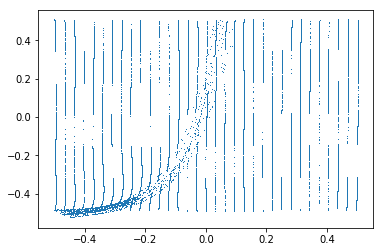

In [12]:
ae.save_fit('newton_solve.csv','T,p,rho,h',sess=session,samples=10)

In [ ]:
prv = session.run(ae.vars['dec_W_select'])
for i in range(3):
    la,new = session.run([ae.goal_all, newt_select])
    print(la,[np.linalg.norm(n-p) for n,p in zip(new,prv) ])
    prv = new

In [ ]:
ae.save_fit('newton_solve2.csv','T,p,rho,h',sess=session,samples=10)